# Proximal Policy Optimization

In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
import random
import imageio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [8]:
class RoverGridEnv(gym.Env):
    metadata={'render.modes': ['human']} 
    def __init__(self,max_ts=20):     
        super(RoverGridEnv,self).__init__()
        self.max_ts=max_ts      # Note: The Max_Timestamps is set to 20 by default.
        self.grid_size=(15,15)   
        self.action_space=spaces.Discrete(5) 
        self.observation_space=spaces.MultiDiscrete([15,15,15,15,15,15])
        self.rover_positions=np.array([[6,4],[10,4]])
        self.operation_desks=np.array([[6,3],[10,3]])
        self.rooms=np.array([[4,7],[4,10],[4,13],[8,7],[8,10],[8,13],[12,7],[12,10],[12,13]])
        self.human_position=np.array([8,9])
        self.targets=np.array([[5,10],[9,13]])
        self.actions=[(0,-1),(0,1),(-1,0),(1,0),(0,0)]  # Down,Up,Left,Right,Wait
        self.rover_done=[False,False] 
        self.reset()
    
    def seed(self,seed=None):
        np.random.seed(seed)
        random.seed(seed)
        
    def reset(self):
        self.current_step=0
        self.rover_positions=np.array([[6,4],[10,4]])
        self.rover_done=[False,False]
        self.human_position=np.array([7,8])
        self.current_step=0
        return self._get_obs()
    
    def _get_obs(self):
        return np.concatenate((self.rover_positions.flatten(),self.human_position))
    
    def step(self,actions):
        rewards=np.zeros(2)
        done=[False,False]
        info={'message': ''}        
        for i,action in enumerate(actions):
            if self.rover_done[i]:
                done[i]=True 
                continue
            prev_distance=np.linalg.norm(self.targets[i]-self.rover_positions[i])
            if self._is_human_adjacent(self.rover_positions[i]):
                rewards[i] -= 5
            else:
                delta=np.array(self.actions[action])
                new_position=self.rover_positions[i]+delta
                if self._out_of_bounds(new_position):
                    rewards[i] -= 15
                    continue
                if self._collision(new_position,i):
                    rewards[i] -= 15
                    continue
                self.rover_positions[i]=new_position
                new_distance=np.linalg.norm(self.targets[i]-new_position)
                if new_distance < prev_distance:
                    rewards[i]+=30 
                else:
                    rewards[i] -= 20 
                if np.array_equal(new_position,self.targets[i]):
                    rewards[i]+=100
                    self.rover_done[i]=True 
                    done[i]=True

        # move human randomly
        self._move_human()
        self.current_step+=1
        all_done=all(done) or self.current_step >= self.max_ts
        if all_done and not all(done):  # if the maximum number of steps is reached but not all targets were reached
            info['message']='Maximum number of timestamps reached'
        return self._get_obs(),rewards,all_done,info

    def _is_human_adjacent(self,position):
        for delta in [(1,1),(1,-1),(-1,1),(-1,-1)]:
            adjacent_position=position+np.array(delta)
            if np.array_equal(adjacent_position,self.human_position):
                return True
        return False

    def _out_of_bounds(self,position):
        return not (0 <= position[0] < self.grid_size[0] and 0 <= position[1] < self.grid_size[1])
    
    def _collision(self,new_position,rover_index):
        if any(np.array_equal(new_position,pos) for pos in np.delete(self.rover_positions,rover_index,axis=0)):
            return True  # Collision with the other rover
        if any(np.array_equal(new_position,pos) for pos in self.rooms):
            return True  # Collision with a room
        if any(np.array_equal(new_position,pos) for pos in self.operation_desks):
            return True  # Collision with an operation desk
        if np.array_equal(new_position,self.human_position):
            return True  # Collision with the human
        return False
    
    def _move_human(self):
        valid_moves=[move for move in self.actions if not self._out_of_bounds(self.human_position+np.array(move))]
        self.human_position+=np.array(valid_moves[np.random.choice(len(valid_moves))])
    
    def render(self,mode='human',save_path=None):
        fig,ax=plt.subplots(figsize=(7,7))
        ax.set_xlim(0,self.grid_size[0])
        ax.set_ylim(0,self.grid_size[1])
        ax.set_xticks(np.arange(0,15,1))
        ax.set_yticks(np.arange(0,15,1))
        ax.grid(which='both')

        # draw elements
        for pos in self.rover_positions:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='blue'))
        for pos in self.operation_desks:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='darkgreen'))
        for pos in self.rooms:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='black'))
        ax.add_patch(Rectangle((self.human_position[0]-0.5,self.human_position[1]-0.5),1,1,color='purple'))
        for pos in self.targets:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='yellow',alpha=0.5))

        if save_path is not None:
            plt.savefig(save_path)
            plt.close()
    
    def close(self):
        plt.close()

Initial Setup


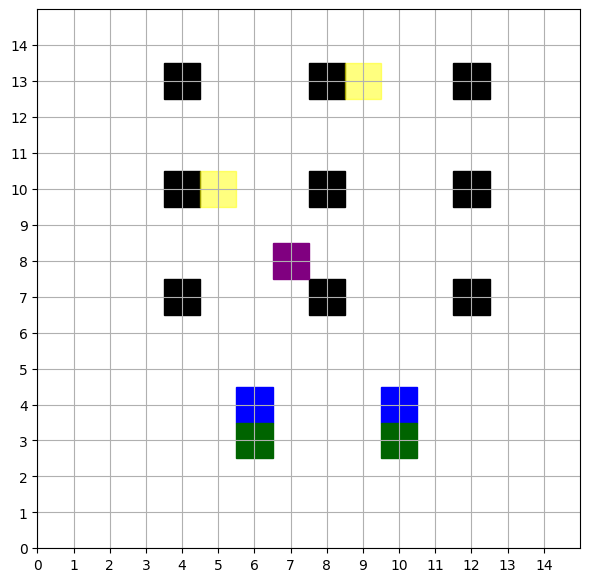

In [9]:
env=RoverGridEnv()
print("Initial Setup")
observation=env.reset()
env.render()

# PPO

In [10]:
class ActorCritic(nn.Module):
    def __init__(self,
                 input_dim,
                 n_actions):
        super(ActorCritic,self).__init__()
        self.fc1=nn.Linear(input_dim,128)
        self.fc2=nn.Linear(128,64)
        self.actor=nn.Linear(64,n_actions)
        self.critic=nn.Linear(64,1)

    def forward(self,x):
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        policy_logits=self.actor(x)
        value=self.critic(x)
        return policy_logits,value

def compute_advantages(rewards,
                       values,
                       next_values,
                       gamma=0.99,
                       lambda_=0.95):
    deltas=rewards+gamma*next_values-values
    advantages=[]
    advantage=0
    for delta in reversed(deltas):
        advantage=delta+gamma*lambda_*advantage
        advantages.insert(0,advantage)
    return torch.tensor(advantages,dtype=torch.float32)

In [17]:
def train_ppo(env,
              actor_critic,
              optimizer,
              total_timesteps=10000,
              gamma=0.99,
              lambda_=0.95,
              epsilon=0.2,
              epochs=3,
              batch_size=64):
    
    episode_rwds_ppo=[]
    for _ in range(total_timesteps // batch_size):
        obs=env.reset()
        obs_list,action_list,reward_list,value_list,logprob_list=[],[],[],[],[]
        total_episode_reward=0
        for _ in range(batch_size):
            obs_tensor=torch.tensor(obs,
                                      dtype=torch.float32).unsqueeze(0)
            policy_logits,value=actor_critic(obs_tensor)
            dist=Categorical(logits=policy_logits)
            action=dist.sample()
            obs_list.append(obs)
            action_list.append(action.item())
            reward_list.append(0)
            value_list.append(value.item())
            logprob_list.append(dist.log_prob(action).item())
            obs,rewards,done,_=env.step([action.item(),
                                              action.item()])
            reward_list[-1]=rewards.sum()
            total_episode_reward+=rewards.sum()
            if done:
                episode_rwds_ppo.append(total_episode_reward)
                print(f"Episode {len(episode_rwds_ppo)} ended with reward: {total_episode_reward}")
                obs=env.reset()
                total_episode_reward=0
                break
        obs_tensor=torch.tensor(np.array(obs_list),
                                  dtype=torch.float32)
        action_tensor=torch.tensor(action_list)

        reward_tensor=torch.tensor(reward_list,
                                     dtype=torch.float32)
        value_tensor=torch.tensor(value_list,
                                    dtype=torch.float32)
        logprob_tensor=torch.tensor(logprob_list,
                                      dtype=torch.float32)
        advantages=compute_advantages(reward_tensor,
                                        value_tensor,
                                        torch.cat((value_tensor[1:],
                                                   torch.tensor([0])),
                                                   axis=0),
                                        gamma,
                                        lambda_)

        for _ in range(epochs):
            new_policy_logits,new_values=actor_critic(obs_tensor)
            new_dist=Categorical(logits=new_policy_logits)
            new_logprobs=new_dist.log_prob(action_tensor)
            ratio=torch.exp(new_logprobs-logprob_tensor)
            surr1=ratio*advantages
            surr2=torch.clamp(ratio,
                                1-epsilon,
                                1+epsilon)*advantages
            policy_loss=-torch.min(surr1,surr2).mean()
            value_loss=nn.MSELoss()(new_values.squeeze(),
                                      reward_tensor)
            loss=policy_loss+0.5*value_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return episode_rwds_ppo

In [18]:
env=RoverGridEnv()
input_dim=env.observation_space.shape[0]
n_actions=env.action_space.n
actor_critic=ActorCritic(input_dim,
                           n_actions)
optimizer=optim.Adam(actor_critic.parameters(),
                       lr=1e-3)
episode_rwds_ppo=train_ppo(env,
                             actor_critic,
                             optimizer,
                             total_timesteps=50000)

Episode 1 ended with reward: -370.0
Episode 2 ended with reward: -30.0
Episode 3 ended with reward: -90.0
Episode 4 ended with reward: -285.0
Episode 5 ended with reward: 35.0
Episode 6 ended with reward: 355.0
Episode 7 ended with reward: 190.0
Episode 8 ended with reward: 425.0
Episode 9 ended with reward: 710.0
Episode 10 ended with reward: 455.0
Episode 11 ended with reward: 110.0
Episode 12 ended with reward: 150.0
Episode 13 ended with reward: 140.0
Episode 14 ended with reward: 50.0
Episode 15 ended with reward: 150.0
Episode 16 ended with reward: 60.0
Episode 17 ended with reward: 60.0
Episode 18 ended with reward: 220.0
Episode 19 ended with reward: 160.0
Episode 20 ended with reward: 120.0
Episode 21 ended with reward: 345.0
Episode 22 ended with reward: 50.0
Episode 23 ended with reward: 170.0
Episode 24 ended with reward: 130.0
Episode 25 ended with reward: 115.0
Episode 26 ended with reward: 375.0
Episode 27 ended with reward: 150.0
Episode 28 ended with reward: 110.0
Epis

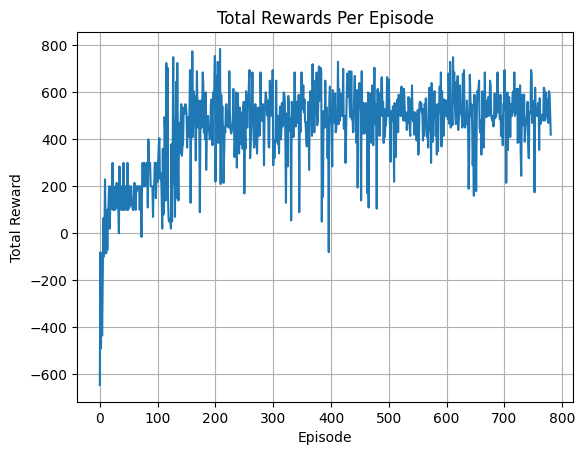

In [ ]:
plt.plot(episode_rwds_ppo)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Per Episode")
plt.grid(True)
plt.show()

C:\Users\91740\AppData\Local\Temp\ipykernel_8108\1561640575.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(path) for path in frames_paths]


Episode 1 evaluated, GIF saved to eval_gifs\episode_1.gif.
Episode 2 evaluated, GIF saved to eval_gifs\episode_2.gif.
Episode 3 evaluated, GIF saved to eval_gifs\episode_3.gif.
Episode 4 evaluated, GIF saved to eval_gifs\episode_4.gif.
Episode 5 evaluated, GIF saved to eval_gifs\episode_5.gif.
Episode 6 evaluated, GIF saved to eval_gifs\episode_6.gif.
Episode 7 evaluated, GIF saved to eval_gifs\episode_7.gif.
Episode 8 evaluated, GIF saved to eval_gifs\episode_8.gif.
Episode 9 evaluated, GIF saved to eval_gifs\episode_9.gif.
Episode 10 evaluated, GIF saved to eval_gifs\episode_10.gif.


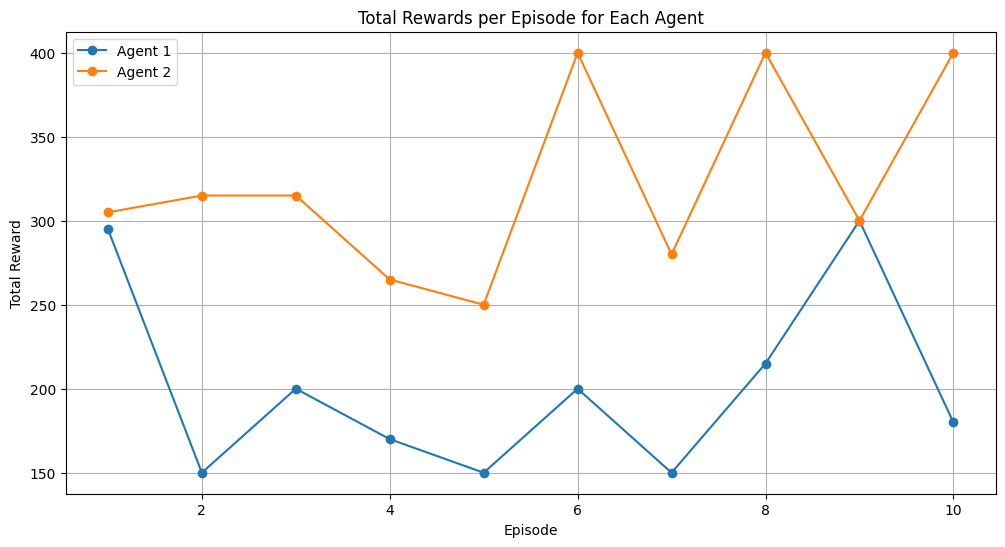

In [ ]:
def evaluate_ppo_agent(env,
                       actor_critic,
                       num_episodes=10,
                       output_dir='eval_gifs'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    eval_episode_rwds=[]     
    for episode in range(num_episodes):
        obs=env.reset()
        episode_rwds_ppo=np.zeros((2,))
        frames_paths=[]
        done=False
        timestep=0
        while not done:
            with torch.no_grad():
                obs_tensor=torch.tensor(obs,
                                          dtype=torch.float32).unsqueeze(0)
                policy_logits,_=actor_critic(obs_tensor)
                action1=Categorical(logits=policy_logits).sample().item()
                action2=Categorical(logits=policy_logits).sample().item()
            next_obs,rewards,done,_=env.step([action1,
                                                   action2])
            episode_rwds_ppo+=rewards 
            obs=next_obs
            frame_path=os.path.join(output_dir,
                                      f"episode_{episode+1}_frame_{timestep}.png")
            env.render(save_path=frame_path) 
            frames_paths.append(frame_path)            
            timestep+=1
        eval_episode_rwds.append(episode_rwds_ppo) 
    
        frames=[imageio.imread(path) for path in frames_paths]
        gif_path=os.path.join(output_dir,f"episode_{episode+1}.gif")
        imageio.mimsave(gif_path,frames,fps=10) 
        for path in frames_paths:
            os.remove(path)
        print(f"Episode {episode+1} evaluated, GIF saved to {gif_path}.")

    eval_episode_rwds=np.array(eval_episode_rwds)  
    plt.figure(figsize=(12,6))
    for agent_index in range(2):
        plt.plot(range(1,num_episodes+1),eval_episode_rwds[:,agent_index],marker='o',label=f'Agent {agent_index+1}')
    plt.title('Total Rewards per Episode for Each Agent')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir,'rewards_plot.png'))
    plt.show()

evaluate_ppo_agent(env,actor_critic,num_episodes=10)